In [8]:
import numpy as np
import torch
from scipy.stats import norm, multivariate_normal
import matplotlib.pyplot as plt
from plot_functions import *

# Load Posterior Samples

In [9]:
name = "NPE_C"

In [10]:
# --- Load simulated data ---
alpha_IMF_obs = np.load(f"data/alpha_IMF_obs_{name}.npy")
log10_N_Ia_obs = np.load(f"data/log10_N_Ia_obs_{name}.npy")

In [11]:
simulations = 1000
N_stars = 1000
global_params = np.array([[-2.3, -2.89]])

# Predict Multistar Posterior
We can compute the posterior for a single star from the samples created in ```03_sample_from_posterior.ipynb```. <br>
Because of the central limit theorem, we can write the posterior for a single star as a multivariate Gaussian. <br>
This gives us the mean and covariance of $\alpha_{IMF}$ and $log{N_{Ia}}$ for one observation. <br>

We can then combine the posterior for multiple stars to get the posterior for the entire dataset. <br>
$$ 
\begin{align*}
P(\theta| data) &\propto \prod_{i=1}^{N_{stars}} P(\theta| obs_i) \\ \\
&\propto \prod_{i=1}^{N_{stars}} \exp\left(-\frac{1}{2} \frac{(\theta-\mu_i)^2}{\sigma_i^2}\right)
\end{align*} 
$$

This is a product of Gaussians, so the posterior for the entire dataset is also a Gaussian with mean $\mathbf{\mu}$ and variance $\mathbf{\sigma}$. <br>
$$
\begin{align*}
\mathbf{\mu} &= \frac{\sum_{i=1}^{N_{stars}} \frac{\mu_i}{\sigma_i^2}}{\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}} \\ \\
\mathbf{\sigma}^2 &= \frac1 {\sum_{i=1}^{N_{stars}} \frac1{\sigma_i^2}}
\end{align*}
$$

In [12]:
# Calculate mean and std for each observation
mu_alpha, sigma_alpha = alpha_IMF_obs.mean(axis=1), alpha_IMF_obs.std(axis=1)
mu_N_Ia, sigma_N_Ia = log10_N_Ia_obs.mean(axis=1), log10_N_Ia_obs.std(axis=1)

# Calculate mean and std for joint distribution
mu_alpha_combined = np.sum(mu_alpha/sigma_alpha**2)/np.sum(1/sigma_alpha**2)
sigma_alpha_combined = 1/np.sqrt(np.sum(1/sigma_alpha**2))

mu_N_Ia_combined = np.sum(mu_N_Ia/sigma_N_Ia**2)/np.sum(1/sigma_N_Ia**2)
sigma_N_Ia_combined = 1/np.sqrt(np.sum(1/sigma_N_Ia**2))

In [13]:
print(f"alpha_IMF = {mu_alpha_combined:.3f} +/- {sigma_alpha_combined:.3f}")
print(f"log10_N_Ia = {mu_N_Ia_combined:.3f} +/- {sigma_N_Ia_combined:.3f}")

alpha_IMF = -2.298 +/- 0.003
log10_N_Ia = -2.896 +/- 0.004


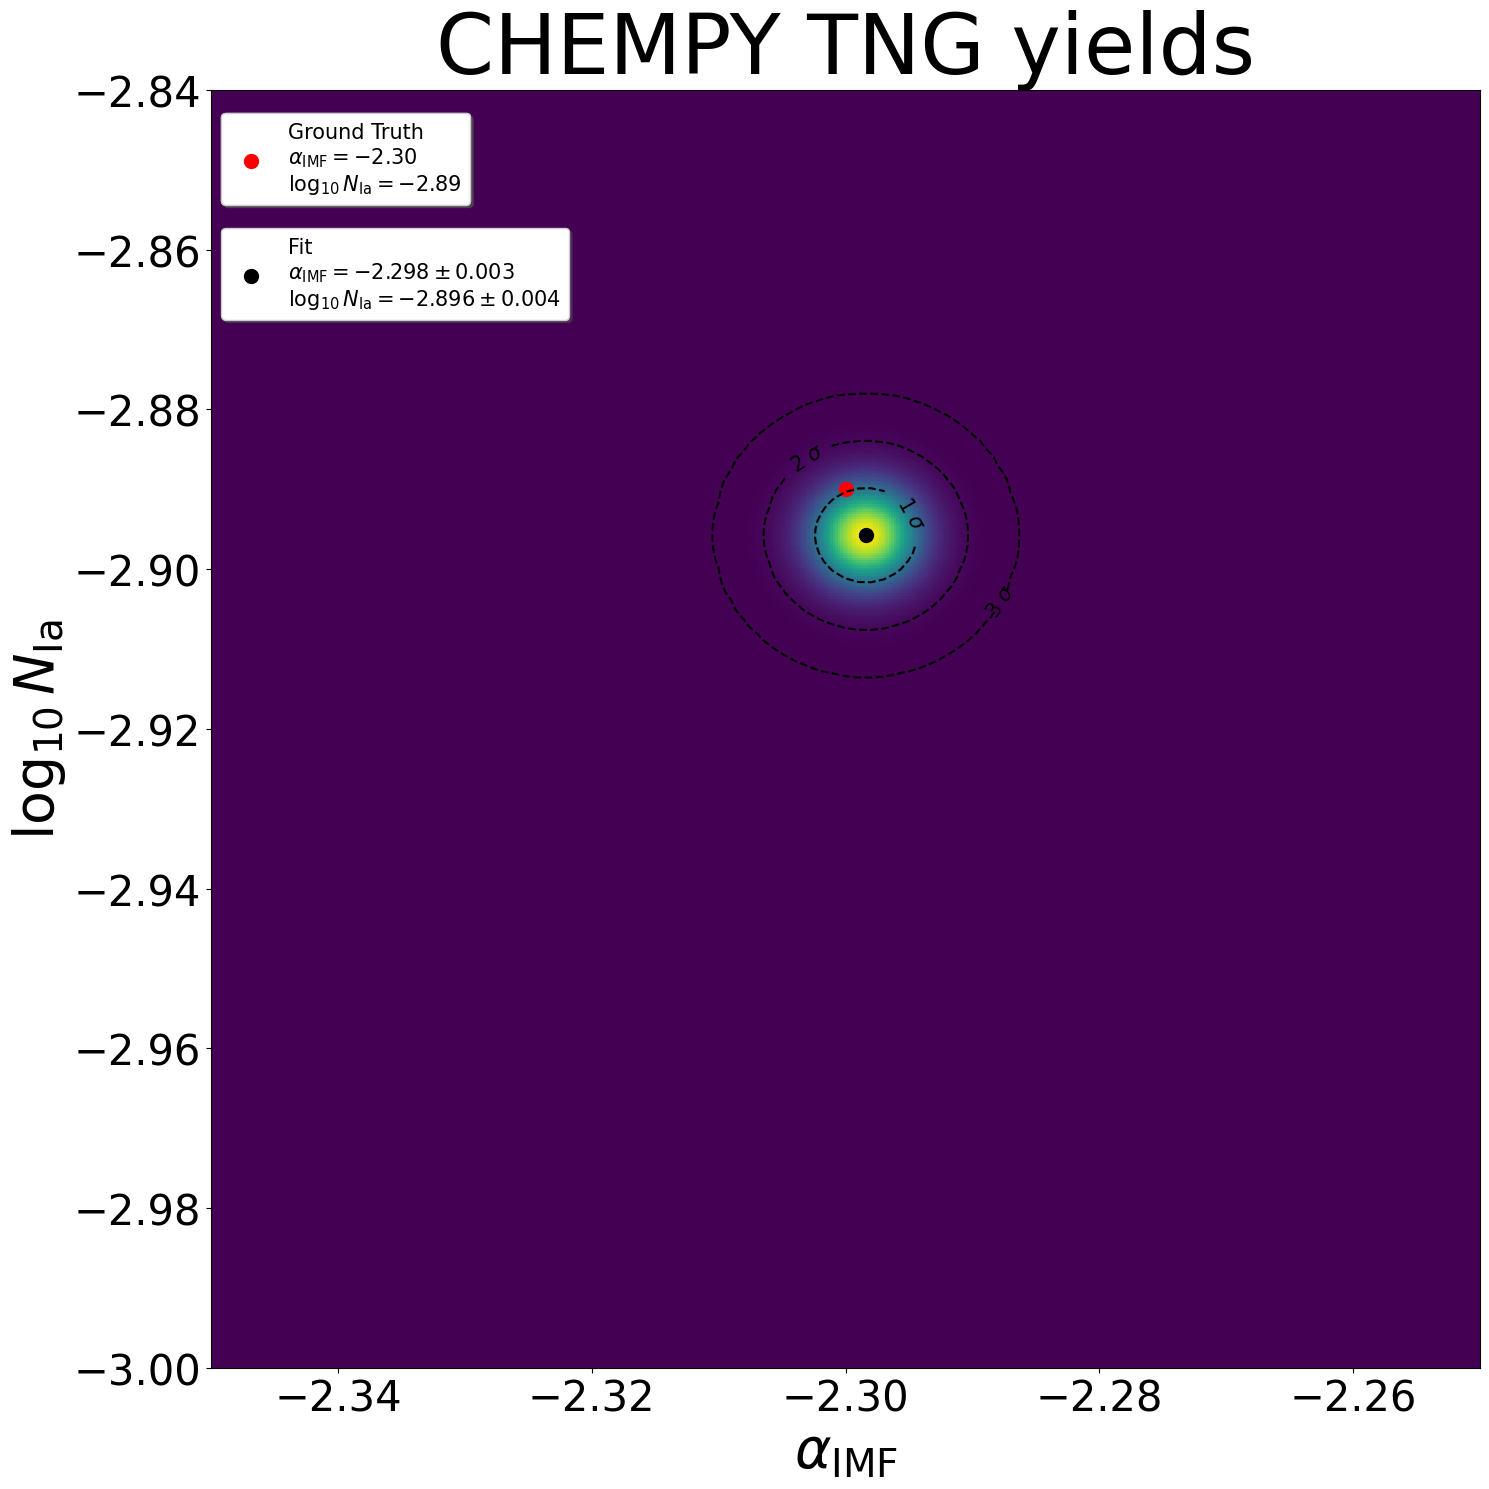

In [14]:
gaussian_posterior_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params, title="CHEMPY TNG yields")

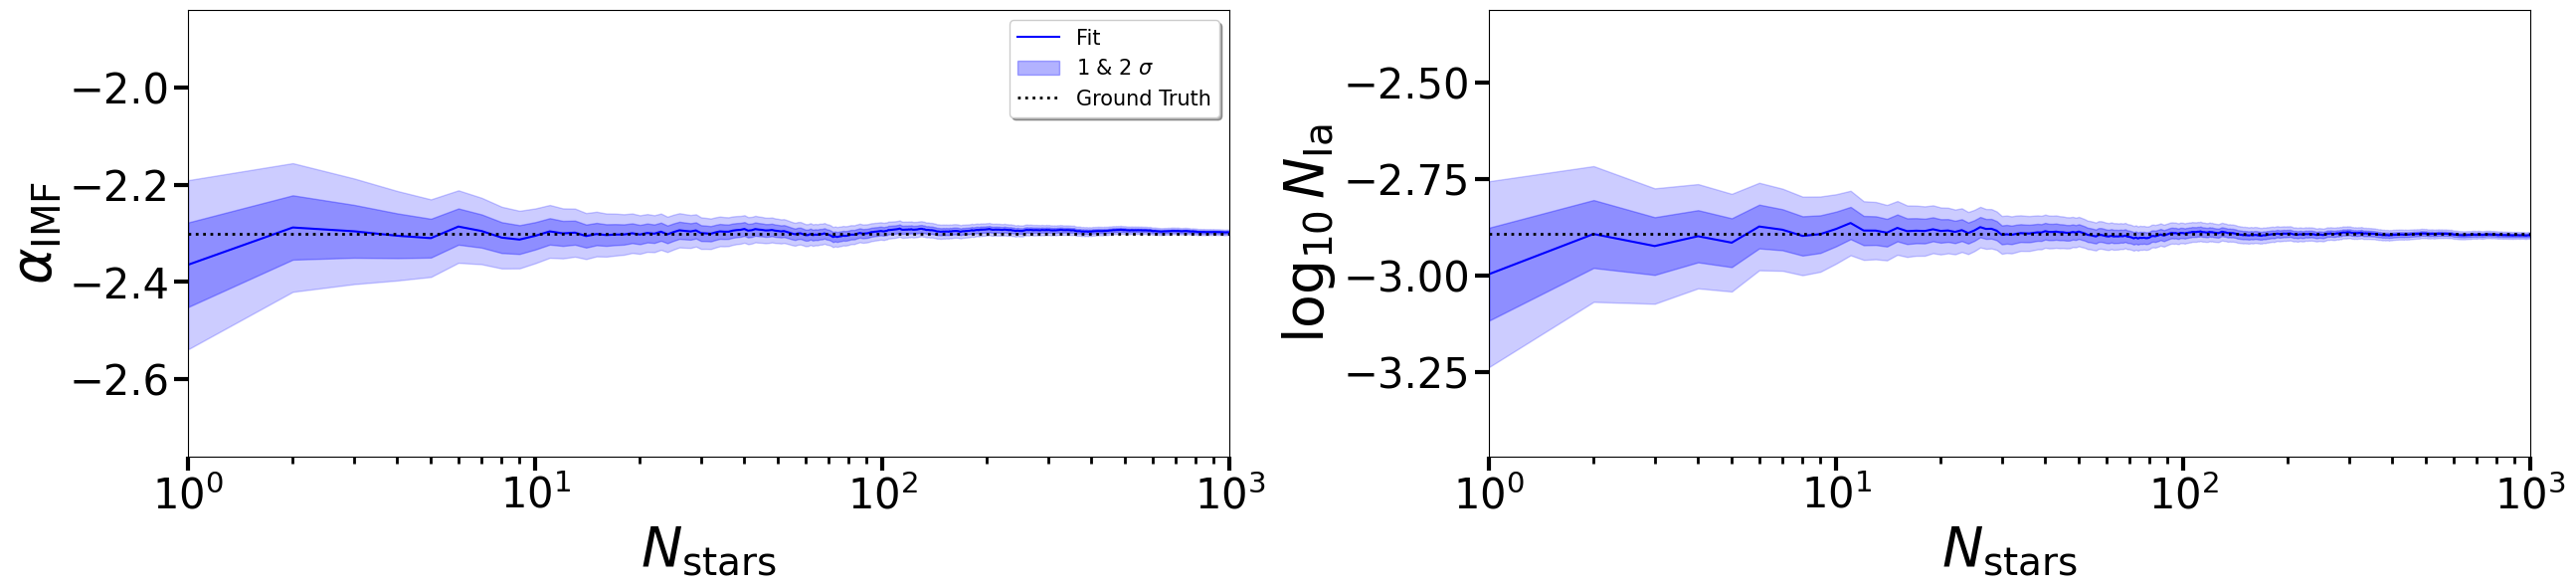

In [15]:
stars = np.arange(1,1000)
n_stars_plot(alpha_IMF_obs, log10_N_Ia_obs, global_params, "CHEMPY TNG yields N_star", stars)

## Compare to HMC

In [16]:
dat = np.load('data/chempy_data_paper/Inference_Output.npz', allow_pickle=True)

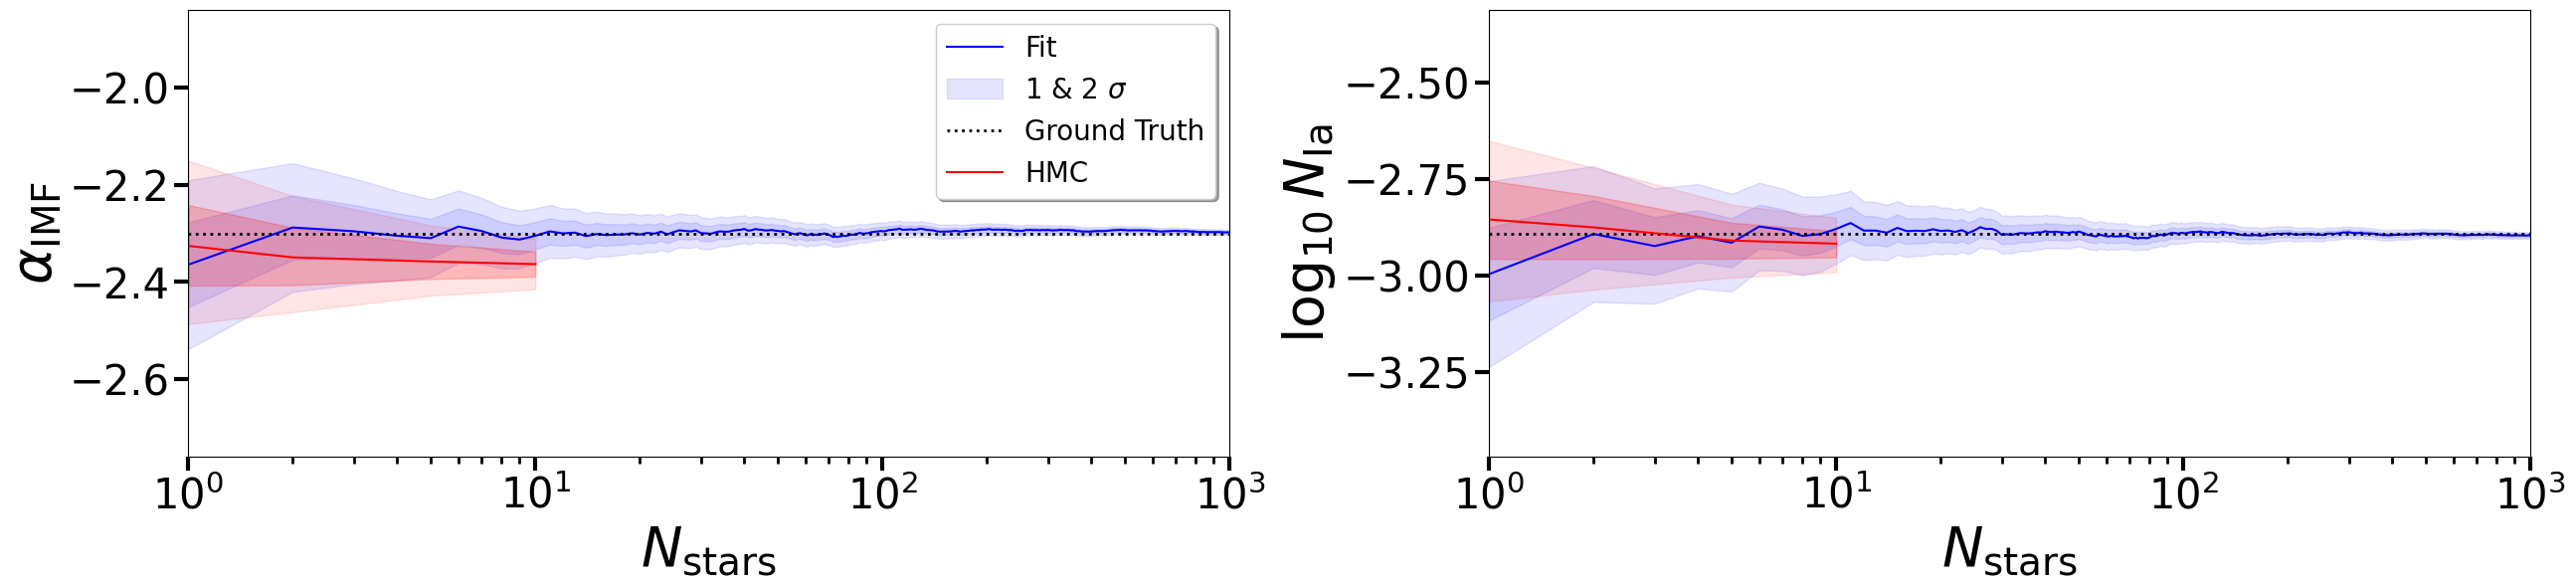

In [17]:
stars = np.arange(1,1000)
n_stars_plot_comp(alpha_IMF_obs, log10_N_Ia_obs, global_params, dat, "CHEMPY TNG yields N_star comp", stars)